<center> <a href="https://github.com/CyConProject?tab=repositories">
  <img src="https://github.com/CyConProject/Lab/blob/main/Figures/CyCon.png?raw=true" alt="logo" width="80" >
</a>
 </center>


# Agglomerative Clustering

In this lab, we will explore **Agglomerative Clustering**, a bottom-up hierarchical clustering method often used for discovering inherent groupings within data. By mastering this technique, you'll be able to cluster projects or entities based on shared characteristics, which is valuable in the construction and civil engineering fields.

Imagine grouping construction projects by budget, duration, workforce size, and materials used. This clustering can help identify patterns—such as which types of projects typically have higher safety incidents or longer timelines—thus enabling better resource allocation and risk management strategies.

Agglomerative Clustering starts by treating each data point as an individual cluster. It then repeatedly merges the two closest clusters until it forms the desired number of clusters (or until all points form one cluster). Different linkage criteria (e.g., **complete**, **average**, **ward**) determine how distances between clusters are measured.

### Objectives:

During this lab, we will focus on several key aspects of Agglomerative Clustering:

- **Data Preparation**: Load and inspect a construction project dataset, and convert categorical features into numerical form.
- **Feature Selection & Scaling**: Select the most relevant features and apply scaling to ensure that all features contribute equally to distance calculations.
- **Model Building**: Construct and fit an Agglomerative Clustering model to discover underlying clusters in the dataset.
- **Model Evaluation & Visualization**: Evaluate cluster quality using metrics like the Silhouette Score, and visualize clusters to interpret results.
- **Dimensionality Reduction with PCA**: Apply Principal Component Analysis (PCA) to reduce the dimensionality of the data.

By the end of this lab, you will have a solid understanding of how Agglomerative Clustering can help group construction projects by similarities—providing insights into project management, resource allocation, and risk assessment.

## Step 1: Import necessary libraries


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# For dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Configure visual settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## Step 2: Load the dataset

In this step, we load a **synthetic construction projects** dataset. This dataset contains details about various construction projects, including budget, duration, number of workers, safety incidents, and other project attributes.

In [87]:
# Load the dataset
data = pd.read_csv('https://raw.githubusercontent.com/CyConProject/Lab/main/Datasets/Synthetic_Construction_Projects_Dataset_Missing_Values.csv')

# Display the first few rows of the dataset
data.head()

,Budget (USD),Duration (Months),NumWorkers,SafetyIncidents,Location,ProjectType,MaterialType,ProjectPhase
0,8.019766e+05,13.909114,25.0,0,Los Angeles,Infrastructure,Wood,Execution
1,4.462831e+06,41.549995,249.0,11,New York,Industrial,Wood,Closing
2,2.878828e+06,38.596890,240.0,7,Phoenix,Infrastructure,Steel,Closing
3,4.587195e+06,27.338770,264.0,10,Los Angeles,Infrastructure,Wood,Planning
4,4.633083e+06,49.706087,232.0,10,Los Angeles,Infrastructure,Wood,Closing


### Dataset Description

- **Budget (USD)**: The total budget allocated for the project in USD.
- **Duration (Months)**: The total planned duration of the project in months.
- **NumWorkers**: The number of workers assigned to the project.
- **SafetyIncidents**: The recorded number of safety incidents during the project timeline.
- **Location**: The city where the project is located (e.g., Los Angeles, New York, etc.).
- **ProjectType**: The broad category of the project (e.g., Infrastructure, Industrial, Commercial, Residential).
- **MaterialType**: The primary construction material used (e.g., Wood, Steel, Brick).
- **ProjectPhase**: The phase of the project (e.g., Planning, Execution, Closing).

These features will help us cluster projects that share similar traits, which can inform resource allocation and risk management in the construction sector.

## Step 3: Pre-processing
### 3.1 Handling Missing Data
First, let’s see if there are any missing values in the dataset:

In [88]:
missing_counts = data.isnull().sum()
print(missing_counts)

Budget (USD)         1
Duration (Months)    0
NumWorkers           1
SafetyIncidents      0
Location             1
ProjectType          0
MaterialType         1
ProjectPhase         0
dtype: int64


Some columns have missing values, and we can choose an appropriate strategy. For example, we can drop rows with too many missing values, or fill them with a mean/median/mode. Here, there is minimal missingness, so we drop rows that have missing data for simplicity (though in a real scenario, you might prefer a more nuanced approach):

In [89]:
# Drop rows with any missing value
data.dropna(inplace=True)

# Verify no more missing values
data.isnull().sum()

Budget (USD)         0
Duration (Months)    0
NumWorkers           0
SafetyIncidents      0
Location             0
ProjectType          0
MaterialType         0
ProjectPhase         0
dtype: int64


### 3.2 Encoding Categorical Features

Agglomerative Clustering uses distance-based calculations, so all features need to be numeric. We will use **LabelEncoder** to convert categorical columns (`Location`, `ProjectType`, `MaterialType`, `ProjectPhase`) into numerical form.

In [90]:
categorical_cols = ['Location', 'ProjectType', 'MaterialType', 'ProjectPhase']

# Dictionary to store encoders if we need them later
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

data.head()

,Budget (USD),Duration (Months),NumWorkers,SafetyIncidents,Location,ProjectType,MaterialType,ProjectPhase
0,8.019766e+05,13.909114,25.0,0,3,2,4,1
1,4.462831e+06,41.549995,249.0,11,4,1,4,0
2,2.878828e+06,38.596890,240.0,7,6,2,3,0
3,4.587195e+06,27.338770,264.0,10,3,2,4,2
4,4.633083e+06,49.706087,232.0,10,3,2,4,0


## Step 4: Feature Selection

For clustering, we will consider the following features: 

1. **Budget (USD)** 
2. **Duration (Months)** 
3. **NumWorkers** 
4. **SafetyIncidents** 
5. **Location** 
6. **ProjectType** 
7. **MaterialType** 
8. **ProjectPhase**

Feel free to adjust this selection based on your analysis or domain knowledge. For instance, you might exclude `Location` if it’s too diverse or strongly correlated with other variables.

In [91]:
X = data[['Budget (USD)', 
          'Duration (Months)', 
          'NumWorkers', 
          'SafetyIncidents', 
          'Location', 
          'ProjectType', 
          'MaterialType', 
          'ProjectPhase']].copy()

## Step 5: Scaling the Data

Distance-based algorithms like Agglomerative Clustering are sensitive to the scale of features. A feature with large numeric values (e.g., Budget) can dominate the distance metric. Therefore, we use **StandardScaler** to normalize all features to have mean 0 and standard deviation 1.

In [92]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Let's see the transformed data (first 5 rows)
X_scaled[:5]

array([[-1.26573995, -0.92716892, -1.80868799, -1.7176035 , -0.5487883 ,
         0.48514183,  1.47529284, -0.06760761],
       [ 1.3648972 ,  1.36264972,  1.14654706,  1.41612904, -0.20196524,
        -0.41133547,  1.47529284, -1.27005724],
       [ 0.22665545,  1.11800933,  1.02780994,  0.27658994,  0.49168089,
         0.48514183,  0.75641238, -1.27005724],
       [ 1.45426354,  0.18536708,  1.34444227,  1.13124427, -0.5487883 ,
         0.48514183,  1.47529284,  1.13484202],
       [ 1.4872382 ,  2.03831459,  0.92226583,  1.13124427, -0.5487883 ,
         0.48514183,  1.47529284, -1.27005724]])

## Step 6: Building the Agglomerative Clustering Model

### 6.1 Deciding on the Number of Clusters

Unlike supervised learning, clustering does not have a labeled target variable to optimize. Instead, we rely on domain knowledge or cluster quality metrics (like the **Silhouette Score**) to guide the choice of `n_clusters`.

Let’s start by arbitrarily setting `n_clusters = 3` and using `linkage='ward'`. (Other linkage options include `complete`, `average`, and `single`.)

The `ward` linkage minimizes the variance within clusters, leading to more compact and spherical clusters. In contrast, **complete** linkage merges clusters based on the maximum distance between their points (focusing on cluster separation), **average** linkage considers the average distance between all points in the clusters, and **single** linkage merges clusters based on the smallest pairwise distance (which can lead to “chaining” effects). For more detailed explanations, see the [Scikit-Learn Hierarchical Clustering documentation](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering).


In [93]:
# Initialize the Agglomerative Clustering model
agg_model = AgglomerativeClustering(
    n_clusters=3, 
    linkage='ward'
)

# Fit the model
agg_model.fit(X_scaled)

# The cluster labels assigned to each record
labels = agg_model.labels_
print(labels[:20])  # first 20 labels

[1 0 2 0 0 1 0 0 2 0 2 0 1 1 2 0 0 0 0 1]


## Step 7: Evaluating the Clustering

### 7.1 Silhouette Score

One way to evaluate clustering performance is by computing the **Silhouette Score**, which measures how similar each point is to its own cluster compared to other clusters. The score ranges from -1 (poor clustering) to +1 (dense, well-separated clustering).

In [94]:
score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score for n_clusters=3: {score:.3f}")

Silhouette Score for n_clusters=3: 0.178


A Silhouette Score of 0.178 suggests that the clusters are not very well separated—there is considerable overlap between them. This result might indicate that the chosen number of clusters or linkage method may need further refinement for clearer segmentation. A higher Silhouette Score would indicate more distinct and well-defined clusters. Experimenting with different numbers of clusters (`n_clusters`) or different linkage criteria can help find an optimal solution.

## Step 8: Visualizing the Clusters

Because we have 8 features, we cannot directly visualize all of them in 2D. Instead, we can:

1. Choose two features to visualize in a scatter plot.
2. Or reduce dimensionality (e.g., with PCA) to 2D or 3D and plot the resulting components.

Below, we’ll pick two numeric features, such as **Duration (Months)** and **Budget (USD)**, to see if there’s any discernible separation.

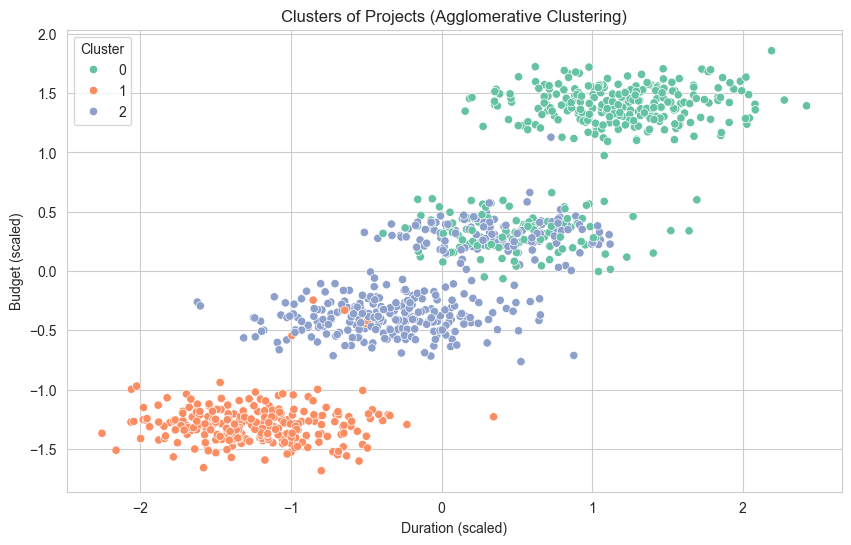

In [95]:
plt.figure(figsize=(10, 6))

# Plot each data point, colored by cluster label
sns.scatterplot(
    x=X_scaled[:, 1],  # Duration is the second column in X
    y=X_scaled[:, 0],  # Budget is the first column in X
    hue=labels,
    palette="Set2"
)

plt.title("Clusters of Projects (Agglomerative Clustering)")
plt.xlabel("Duration (scaled)")
plt.ylabel("Budget (scaled)")
plt.legend(title="Cluster")
plt.show()

## Step 9: Creating a Dendrogram

Although scikit-learn’s `AgglomerativeClustering` doesn’t provide a built-in dendrogram, we can create one using **SciPy**. The dendrogram visually represents how clusters merge at each iteration of the hierarchical algorithm.

1. Compute the pairwise distance matrix with `pdist`.
2. Use `linkage` to define how clusters merge.
3. Plot with `dendrogram`.

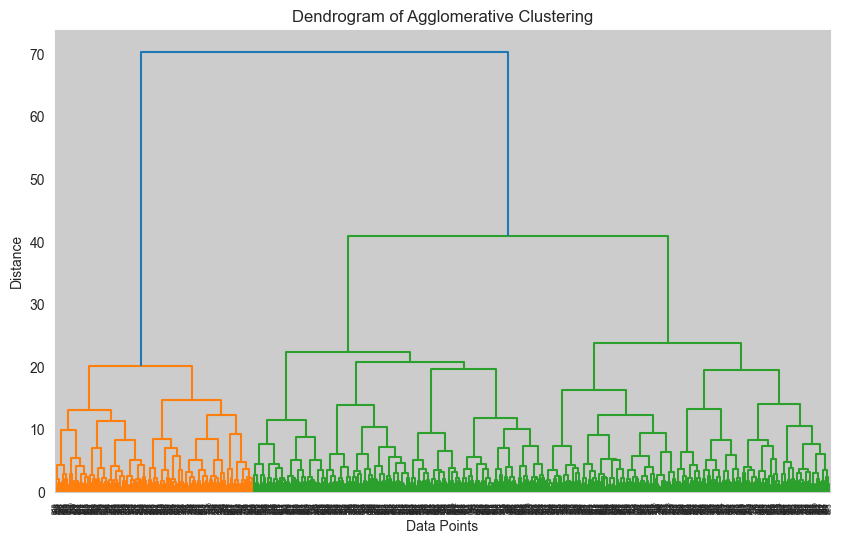

In [96]:
# Step 9.1: Distance matrix
dist_matrix = pdist(X_scaled, metric='euclidean')

# Step 9.2: Linkage matrix
Z = linkage(dist_matrix, method='ward')

# Step 9.3: Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.title("Dendrogram of Agglomerative Clustering")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

The dendrogram can help you visually decide on the number of clusters by “cutting” the tree at a certain distance threshold.

## Practice

1. **Experiment with Different Linkage Methods**  
   Try `linkage='complete'`, `linkage='average'`, or `linkage='single'` in your Agglomerative Clustering model. Compare the Silhouette Scores.

2. **Experiment with Different Numbers of Clusters**  
   Use `n_clusters=2, 3, 4, 5` and compute the Silhouette Score each time. Which `n_clusters` gives the best score?


In [97]:
# Your Code Here


<details><summary><strong>Click here for a possible solution</strong></summary>

```python
# 1. Experiment with different linkage methods
for linkage_method in ['complete', 'average', 'single']:
    agg_model_alt = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
    agg_model_alt.fit(X_scaled)
    labels_alt = agg_model_alt.labels_
    score_alt = silhouette_score(X_scaled, labels_alt)
    print(f"Linkage = {linkage_method}, Silhouette Score = {score_alt:.3f}")

# 2. Experiment with different numbers of clusters
for k in [2, 3, 4, 5]:
    agg_model_k = AgglomerativeClustering(n_clusters=k, linkage='ward')
    agg_model_k.fit(X_scaled)
    labels_k = agg_model_k.labels_
    score_k = silhouette_score(X_scaled, labels_k)
    print(f"n_clusters = {k}, Silhouette Score = {score_k:.3f}")
```

</details>

## Principal Component Analysis (PCA)


**Principal Component Analysis (PCA)** is a powerful dimensionality reduction technique that transforms high-dimensional data into a new coordinate system. In PCA, the first principal component is the direction of maximum variance, meaning it captures the most significant variability in the data. Each subsequent principal component captures the next highest variance while remaining orthogonal (uncorrelated) to the previous components. This process effectively concentrates the essential structure and trends of the data into fewer dimensions, often revealing hidden patterns that are not easily noticeable in the original high-dimensional space.

PCA is particularly beneficial when visualizing data or when trying to reduce noise and redundancy in datasets with many features. By focusing on the principal components that account for the majority of the variance, PCA can help improve clustering performance. This is because the noise and less informative aspects of the data are filtered out, leaving a clearer separation between groups. For further reading, consult the [Scikit-Learn PCA documentation](https://scikit-learn.org/stable/modules/decomposition.html#pca).


Below is an example demonstrating PCA for visualization along with the silhouette score calculation for the PCA-based clustering:

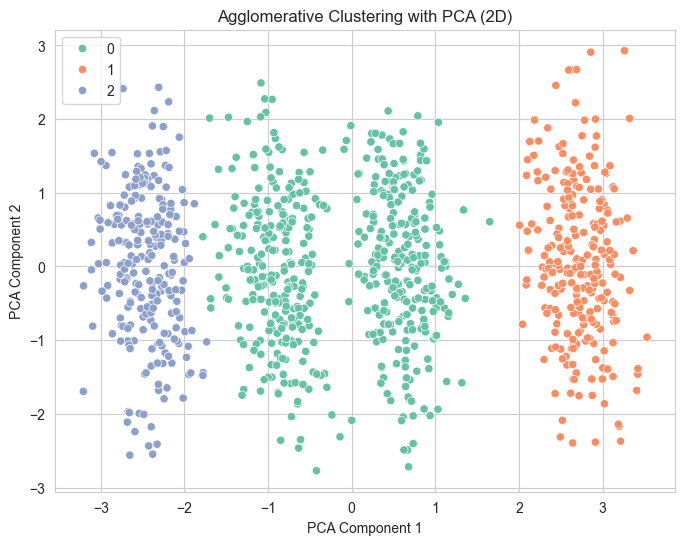

Silhouette Score for PCA-based clustering: 0.413


In [98]:
from sklearn.decomposition import PCA

# Apply PCA to reduce data to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Build and fit the clustering model on the PCA-transformed data
agg_model_pca = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_model_pca.fit(X_pca)
labels_pca = agg_model_pca.labels_

# Visualize the clusters in the PCA-transformed space
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_pca, palette="Set2")
plt.title("Agglomerative Clustering with PCA (2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Compute and print the silhouette score for the PCA-based clustering
pca_score = silhouette_score(X_pca, labels_pca)
print(f"Silhouette Score for PCA-based clustering: {pca_score:.3f}")

After applying PCA to reduce dimensions, we observed a noticeable improvement in the clustering results. When evaluating the PCA-reduced 2D data, the silhouette score increased significantly from 0.178 (without PCA) to 0.413. 


This improvement indicates that the PCA transformation has emphasized the underlying structure of the data by removing noise and redundant features, which in turn leads to more well-defined and separated clusters. It demonstrates that even though PCA reduces the dimensionality, it can retain—or even enhance—the most important relationships among data points for clustering purposes.


Agglomerative Clustering can be a powerful method for discovering hidden patterns in construction projects—helping you group similar projects together for better resource planning, risk assessment, and strategic decision-making. By experimenting with different linkage methods and cluster counts, you can tailor the clustering results to your specific objectives and domain knowledge.

**Good luck and happy clustering!**